# 03-estimate-cheating-adoption-time.ipynb

In this section, we need the records of cheaters between March 1 and March 31.

1. Calculate the average kill ratio of cheaters.
* Calculate the average kill interval of cheaters.
* Estimate the start date of cheating for each cheater based on performance.
* Store the results in the S3 bucket.

## Load packages and read tables.

In [1]:
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Read a table that contains edges.
spark.read.parquet("s3://jinny-capstone-data-test/data_for_vic_mech.parquet").createOrReplaceTempView("td")

# Read a table that contains player data.
spark.read.parquet("s3://jinny-capstone-data-test/players.parquet").createOrReplaceTempView("players")

# Create a table of cheaters.
spark.sql("SELECT * FROM players WHERE ban_date <= '2019-03-03'").createOrReplaceTempView("cheaters")

## 1. Calculate the average kill ratio by date.

In [4]:
# Create a dataframe that stores kills done by cheaters.
c_kill_logs = spark.sql("""SELECT mid, src, dst, time, m_date, ban_date 
                           FROM td t JOIN cheaters c ON t.src = c.id""")
c_kill_logs.registerTempTable("c_kill_logs")

# Calculate the number of kills of each cheater by date.
c_kills_by_date = spark.sql("""SELECT src AS id, m_date, COUNT(*) AS kills FROM c_kill_logs 
                               GROUP BY src, m_date""")
c_kills_by_date_df = c_kills_by_date.toPandas()

# Create a dataframe that stores death records of cheaters.
spark.sql("""SELECT mid, src, dst, time, m_date, ban_date 
             FROM td t JOIN cheaters c ON t.dst = c.id""").createOrReplaceTempView("c_death_logs")

# Calculate the number of deaths of each cheater by date.
c_deaths_by_date = spark.sql("""SELECT dst AS id, m_date, COUNT(*) AS deaths FROM c_death_logs 
                                GROUP BY dst, m_date""")
c_deaths_by_date_df = c_deaths_by_date.toPandas()

# Create a dataframe that contains both kills and deaths of each cheater by date.
dates_from_kills = c_kills_by_date_df[['id', 'm_date']]
dates_from_deaths = c_deaths_by_date_df[['id', 'm_date']]
temp = pd.concat([dates_from_kills, dates_from_deaths])
temp = temp.drop_duplicates(subset=['id', 'm_date'])

# Merge the two dataframes into one.
kill_info = pd.merge(temp, c_kills_by_date_df, how='outer', on=['id', 'm_date'])
kill_info = kill_info.fillna(0)
merged_df = pd.merge(kill_info, c_deaths_by_date_df, how='outer', on=['id', 'm_date'])
merged_df = merged_df.fillna(0)

# Calculate the kill ratio of each cheater by date.
merged_df['kill_ratio'] = merged_df['kills']/(merged_df['kills']+merged_df['deaths'])
avg_kill_ratio_by_date = merged_df[['id', 'm_date', 'kill_ratio']].sort_values(by=['id', 'm_date'])

# Show the top 20 rows.
print(avg_kill_ratio_by_date.head(20))

                                           id      m_date  kill_ratio
827  account.002dced5b2734143a4133cb58e0d0724  2019-03-01    0.906250
828  account.002dced5b2734143a4133cb58e0d0724  2019-03-02    0.866667
542  account.0087b5d4a4b244279af9138986bf52d3  2019-03-01    0.692308
315  account.00a68dddf4284329aa8b9e7c38481c5a  2019-03-01    0.920502
340  account.010f308648c24b8ebea84187aa518ee9  2019-03-01    0.666667
829  account.012829a2fa344a2884359b4a85e49cb9  2019-03-02    0.888889
460  account.0198bd285eff46c3bf2f6b476566c301  2019-03-01    0.594595
458  account.0198bd285eff46c3bf2f6b476566c301  2019-03-02    0.516129
459  account.0198bd285eff46c3bf2f6b476566c301  2019-03-03    0.593220
356  account.021034455f5141a8b9f3e2d2891c31a6  2019-03-01    1.000000
721  account.0230c074aec741848b646814fb342b61  2019-03-01    0.914634
283  account.028e1de9da8347e8b5dba7edc0e96a42  2019-03-01    0.696970
282  account.028e1de9da8347e8b5dba7edc0e96a42  2019-03-02    0.857143
200  account.0362367

## 2. Calculate the average time difference between consecutive kills by date.

In [5]:
# Get a dataframe that stores kill records of cheaters.
kill_logs = c_kill_logs.toPandas()

# Calculate the time difference between kills for each match
kill_logs = kill_logs.sort_values(['src', 'mid', 'time'])
kill_logs['time'] = pd.to_datetime(kill_logs['time'])
kill_logs['delta'] = kill_logs.groupby(['mid', 'src'])['time'].diff()
kill_logs['delta'] = kill_logs['delta'] / np.timedelta64(1, 's')

# Calculate the average time difference between kills of cheaters by date.
time_diff_df = kill_logs[['src', 'm_date', 'delta']]
avg_kill_interval_by_date = time_diff_df.groupby(['src', 'm_date'], as_index=False).mean()

# Show the top 20 rows.
print(avg_kill_interval_by_date.head(20))

                                         src      m_date       delta
0   account.002dced5b2734143a4133cb58e0d0724  2019-03-01  127.790108
1   account.002dced5b2734143a4133cb58e0d0724  2019-03-02  196.118690
2   account.0087b5d4a4b244279af9138986bf52d3  2019-03-01   92.839667
3   account.00a68dddf4284329aa8b9e7c38481c5a  2019-03-01   93.247789
4   account.010f308648c24b8ebea84187aa518ee9  2019-03-01  172.728800
5   account.012829a2fa344a2884359b4a85e49cb9  2019-03-02  152.545150
6   account.0198bd285eff46c3bf2f6b476566c301  2019-03-01  210.203455
7   account.0198bd285eff46c3bf2f6b476566c301  2019-03-02  165.013196
8   account.0198bd285eff46c3bf2f6b476566c301  2019-03-03  154.072167
9   account.021034455f5141a8b9f3e2d2891c31a6  2019-03-01  121.358000
10  account.0230c074aec741848b646814fb342b61  2019-03-01  111.407652
11  account.028e1de9da8347e8b5dba7edc0e96a42  2019-03-01  283.261133
12  account.028e1de9da8347e8b5dba7edc0e96a42  2019-03-02  309.247000
13  account.036236700880489b9123c5

## 3. Estimate the start date of cheating for each cheater based on performance.

In [6]:
# Create a dataframe that store the performance of cheaters.
avg_kill_interval_by_date.columns = ['id', 'm_date', 'delta']
combined_tab = pd.merge(avg_kill_ratio_by_date, avg_kill_interval_by_date, how='left', on=['id', 'm_date'])

combined_tab['kill_ratio'] = combined_tab['kill_ratio'].round(2)
combined_tab['delta'] = combined_tab['delta'].round(2)
combined_tab['flag'] = 0

# Change the value of flag into one if the record meets the following condition.
combined_tab.loc[(combined_tab['kill_ratio'] >= 0.8) & (combined_tab['delta'] <= 140), 'flag'] = 1
flagged_records =  combined_tab[combined_tab['flag'] == 1]
# print(flagged_records)

start_dates_df = flagged_records.groupby(['id']).first().reset_index()
start_dates = spark.createDataFrame(start_dates_df)
start_dates.registerTempTable("start_dates")
estimation = spark.sql("""SELECT c.id, s.m_date AS start_date, ban_date 
                          FROM cheaters c LEFT JOIN start_dates s ON c.id = s.id""")

# Calculate the period of cheating for each cheater.
estimation_df = estimation.toPandas()
estimation_df['ban_date'] = pd.to_datetime(estimation_df['ban_date'])
estimation_df['start_date'] = pd.to_datetime(estimation_df['start_date'])
estimation_df['period'] = (estimation_df['ban_date'] - estimation_df['start_date']).astype('timedelta64[D]') + 1
print(estimation_df.head(20))

                                          id start_date   ban_date  period
0   account.ba9810e0fcc54fd697c03d76785f5b2c        NaT 2019-03-01     NaN
1   account.61973e29f5fb40118b0548a7fcd6b037        NaT 2019-03-02     NaN
2   account.8d69e352069147749f81d1afc09b71e4        NaT 2019-03-03     NaN
3   account.bcb70098670c4fa08dd2ef69ef49f572        NaT 2019-03-02     NaN
4   account.dc0d711bae2c42c9975872b5bf312761 2019-03-01 2019-03-02     2.0
5   account.feec603d5ae6470994e28180753f623a 2019-03-01 2019-03-01     1.0
6   account.11dbd81ee12c4e9aa6db1a67526dc766        NaT 2019-03-03     NaN
7   account.1c4cf8633d4f4f8db6de95cb093bd9bf        NaT 2019-03-01     NaN
8   account.a98a65311cd54e5dbabee780585a8de0        NaT 2019-03-02     NaN
9   account.da1a6fa0bb694c6ea8e28747fcaf9afe        NaT 2019-03-03     NaN
10  account.eb7c962ec401489fa506035a3c9af311 2019-03-01 2019-03-01     1.0
11  account.8ae9d8e7dbd54358a57caa1e3ed97e2e        NaT 2019-03-02     NaN
12  account.92b450bd57104

In [13]:
# Remove cheaters without start date information.
complete_rows = estimation_df[estimation_df.period.notnull()]
# Resolve the settingwithcopywarning issue.
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
complete_rows['period'] = complete_rows['period'].astype('int') 
print(len(complete_rows))

331


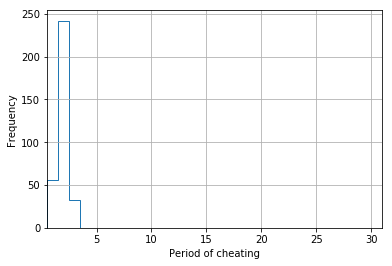

In [10]:
# Plot the distribution of the period of cheating.
# The plot contains cheaters who have full performance information.
bins = np.arange(0, complete_rows['period'].max() + 1.5) - 0.5
fig = complete_rows.hist(bins = bins, histtype='step')
plt.title('')
plt.xlim(xmin = 0.5)
plt.xlim(xmax = 31)
plt.xlabel('Period of cheating')
plt.ylabel('Frequency')
image = plt.show()

In [14]:
# Calculate the mean and median of period of cheating.
print(complete_rows['period'].mean())
print(complete_rows['period'].median())

# Count the number of cheaters who did cheat for two days.
print(len(complete_rows[complete_rows['period']==2]))

1.9305135951661632
2.0
242


In [15]:
# Create a table that contains both start date and ban date of each cheater.
estimation_df = estimation.toPandas()
estimation_df['ban_date'] = pd.to_datetime(estimation_df['ban_date'])
estimation_df['start_date'] = pd.to_datetime(estimation_df['start_date'])
estimation_df['period'] = (estimation_df['ban_date'] - estimation_df['start_date']).astype('timedelta64[D]') + 1

# For cheaters with at least one missing performance information, we assume that they cheated for two days.
estimation_df['period'] = estimation_df['period'].fillna(2)
estimation_df['start_date'] = estimation_df['start_date'].fillna(estimation_df['ban_date'] - pd.to_timedelta(estimation_df['period']-1, unit='d'))
estimation_df['start_date'] = estimation_df['start_date'].astype('str')
estimation_df.loc[(estimation_df['start_date'] < '2019-03-01'), 'start_date'] = '2019-03-01'
estimation_df['start_date'] = pd.to_datetime(estimation_df['start_date'])
estimation_df['period'] = (estimation_df['ban_date'] - estimation_df['start_date']).astype('timedelta64[D]') + 1
print(estimation_df.head(20))

                                          id start_date   ban_date  period
0   account.ba9810e0fcc54fd697c03d76785f5b2c 2019-03-01 2019-03-01     1.0
1   account.61973e29f5fb40118b0548a7fcd6b037 2019-03-01 2019-03-02     2.0
2   account.8d69e352069147749f81d1afc09b71e4 2019-03-02 2019-03-03     2.0
3   account.bcb70098670c4fa08dd2ef69ef49f572 2019-03-01 2019-03-02     2.0
4   account.dc0d711bae2c42c9975872b5bf312761 2019-03-01 2019-03-02     2.0
5   account.feec603d5ae6470994e28180753f623a 2019-03-01 2019-03-01     1.0
6   account.11dbd81ee12c4e9aa6db1a67526dc766 2019-03-02 2019-03-03     2.0
7   account.1c4cf8633d4f4f8db6de95cb093bd9bf 2019-03-01 2019-03-01     1.0
8   account.a98a65311cd54e5dbabee780585a8de0 2019-03-01 2019-03-02     2.0
9   account.da1a6fa0bb694c6ea8e28747fcaf9afe 2019-03-02 2019-03-03     2.0
10  account.eb7c962ec401489fa506035a3c9af311 2019-03-01 2019-03-01     1.0
11  account.8ae9d8e7dbd54358a57caa1e3ed97e2e 2019-03-01 2019-03-02     2.0
12  account.92b450bd57104

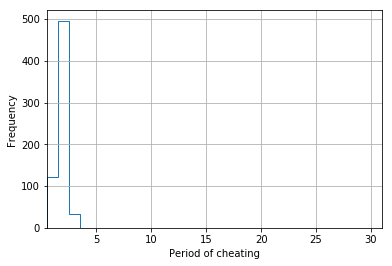

In [17]:
# Plot the distribution of the period of cheating.
# The plot contains all cheaters.
estimation_df['period'] = estimation_df['period'].astype('int')
bins = np.arange(0, estimation_df['period'].max() + 1.5) - 0.5
fig = estimation_df['period'].hist(bins=bins, histtype='step')
plt.title('')
plt.xlim(xmin = 0.5)
plt.xlim(xmax = 31)
plt.xlabel('Period of cheating')
plt.ylabel('Frequency')
image = plt.show()

## 4. Store the results in the S3 bucket.

In [18]:
estimation_df['start_date'] = estimation_df['start_date'].astype('str')
estimation_df['ban_date'] = estimation_df['ban_date'].astype('str')
cheater_info = spark.createDataFrame(estimation_df)
cheater_info.show(20)
cheater_info.write.parquet("s3://jinny-capstone-data-test/cheater_info.parquet")

+--------------------+----------+----------+------+
|                  id|start_date|  ban_date|period|
+--------------------+----------+----------+------+
|account.ba9810e0f...|2019-03-01|2019-03-01|     1|
|account.61973e29f...|2019-03-01|2019-03-02|     2|
|account.8d69e3520...|2019-03-02|2019-03-03|     2|
|account.bcb700986...|2019-03-01|2019-03-02|     2|
|account.dc0d711ba...|2019-03-01|2019-03-02|     2|
|account.feec603d5...|2019-03-01|2019-03-01|     1|
|account.11dbd81ee...|2019-03-02|2019-03-03|     2|
|account.1c4cf8633...|2019-03-01|2019-03-01|     1|
|account.a98a65311...|2019-03-01|2019-03-02|     2|
|account.da1a6fa0b...|2019-03-02|2019-03-03|     2|
|account.eb7c962ec...|2019-03-01|2019-03-01|     1|
|account.8ae9d8e7d...|2019-03-01|2019-03-02|     2|
|account.92b450bd5...|2019-03-02|2019-03-03|     2|
|account.dce592914...|2019-03-01|2019-03-02|     2|
|account.f53b0bcde...|2019-03-01|2019-03-02|     2|
|account.080fb6183...|2019-03-01|2019-03-02|     2|
|account.16b

In [22]:
# Add the information of cheaters to the player data and store it to the S3 bucket for the later use.
cheater_info.registerTempTable("cheater_info")

nodes = spark.sql("""SELECT p.id, p.pname, p.cheating_flag, 
                     CASE WHEN c.start_date IS NULL THEN 'NA' ELSE c.start_date END AS start_date, 
                     CASE WHEN c.ban_date IS NULL THEN 'NA' ELSE c.ban_date END AS ban_date 
                     FROM players p LEFT JOIN cheater_info c ON p.id = c.id""")
# print(nodes.count())
nodes.show(20)
nodes.write.parquet("s3://jinny-capstone-data-test/nodes.parquet")

+--------------------+--------------+-------------+----------+--------+
|                  id|         pname|cheating_flag|start_date|ban_date|
+--------------------+--------------+-------------+----------+--------+
|account.000171894...| Mirage_OwlEye|            0|        NA|      NA|
|account.001017dce...|   rlawltn1012|            0|        NA|      NA|
|account.0014b474d...|blue__lemonade|            0|        NA|      NA|
|account.0017aeb1b...|       k-will0|            0|        NA|      NA|
|account.001b6d0dc...|   kakaonodaab|            0|        NA|      NA|
|account.001c5d052...|      DGU_Ryan|            0|        NA|      NA|
|account.0026c9e0e...|       lkengn0|            0|        NA|      NA|
|account.00272763b...|   BTKnavyseal|            0|        NA|      NA|
|account.0028521c5...|      oyangang|            0|        NA|      NA|
|account.002ba9410...|       SUSAN_2|            0|        NA|      NA|
|account.003114883...|  wkddnwls2335|            0|        NA|  